## Onset asynchrony

## Import dependencies, set constants etc.

In [36]:
from itertools import pairwise

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.nonparametric.kde import KDEUnivariate

from src import utils
import src.visualise.visualise_utils as vutils

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load in data

In [2]:
onsets: list = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

In [3]:
asynchronies = []
# Iterate over every track
for track in onsets:
    if track.item['time_signature'] == 3:
        continue
    temp = pd.DataFrame(track.summary_dict)
    idx = temp[temp['metre_manual'] == 1].index
    # Iterate through successive downbeats
    for downbeat1, downbeat2 in pairwise(idx):
        # Get all the beats marked between our two downbeats (beat 1 bar 1, beat 1 bar 2)
        bw = temp[(downbeat1 <= temp.index) & (temp.index < downbeat2)]
        sub = bw[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
        # Get the first downbeat of the first bar, and the last downbeat of the second
        first, last = temp[temp.index == downbeat1]['beats'].iloc[0], temp[temp.index == downbeat2]['beats'].iloc[0]
        # Scale our onsets to be proportional with our first and last values
        prop = (sub - first) / (last - first)
        # Convert values to degrees
        prop *= 360
        prop = pd.concat([prop, bw['metre_manual']], axis=1)
        # Iterate through each column and add values to our list
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            for _, val in prop[[instr, 'metre_manual']].dropna().iterrows():
                asynchronies.append(dict(instr=instr, asynchrony=val[instr], beat=val['metre_manual']))
df = pd.DataFrame(asynchronies)

In [4]:
df = (
    df.set_index('instr')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

In [5]:
df['asynchrony_adjusted'] = (df['asynchrony'] / 360) - (0.25 * (df['beat'] - 1))

## Create strip plot of asynchrony between instruments

In [46]:
clean = df[(df['asynchrony_adjusted'] >= -1/32) & (df['asynchrony_adjusted'] <= 1/16)][['instr', 'asynchrony_adjusted']]
clean['asynchrony_beat'] = clean['asynchrony_adjusted'] * 4
clean.shape

(255822, 3)

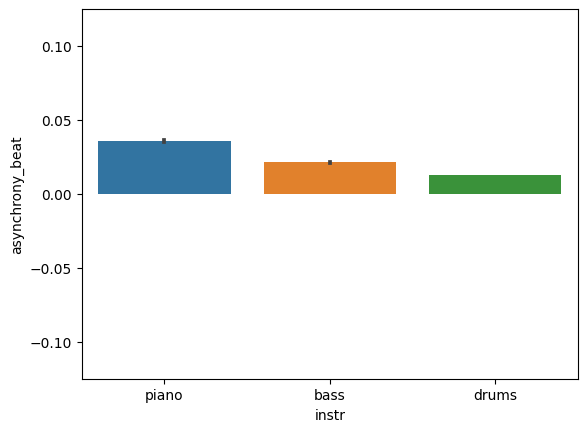

In [32]:
plt.rcParams.update({'font.size': vutils.FONTSIZE})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))
g = sns.barplot(data=clean, x='instr', y='asynchrony_beat', errorbar=('ci', 95), n_boot=100, estimator=np.mean, bottom=0, ax=ax)
g.set(ylim=(-0.125, 0.125))
plt.show()

## Create circular plot of asynchrony by beat number

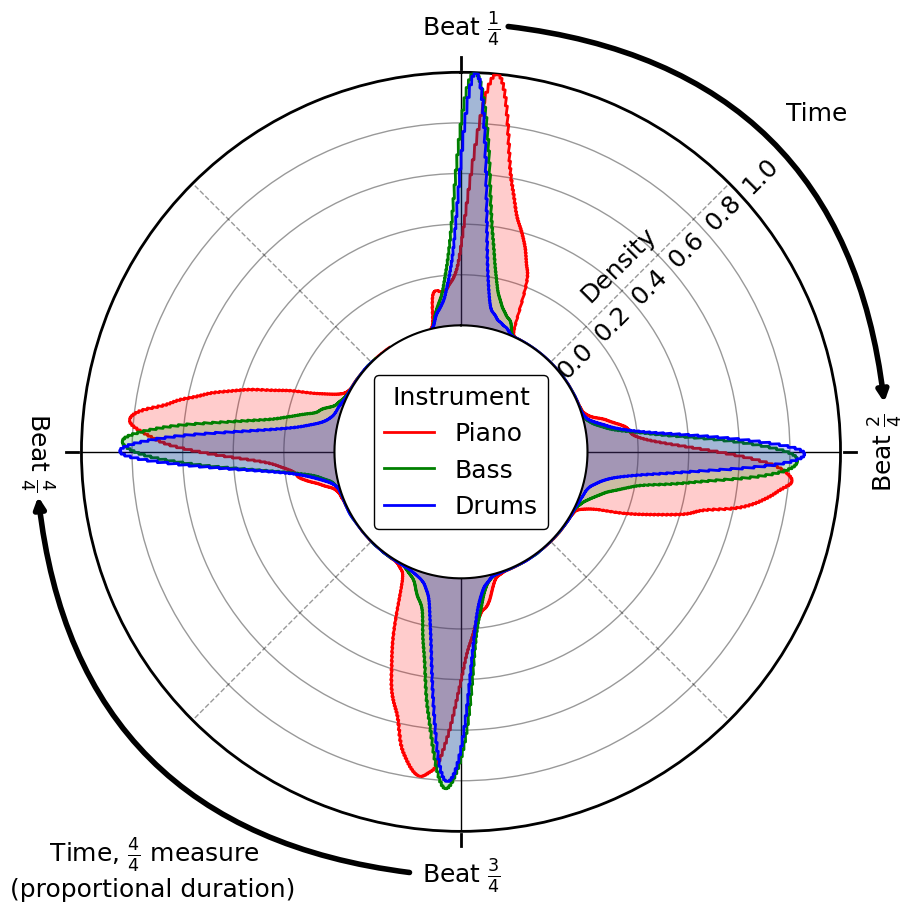

In [44]:
class PolarPlotAsynchrony(vutils.BasePlot):
    N_BINS = 500
    FILL_KWS = dict(step='pre', alpha=vutils.ALPHA / 2, zorder=3,)
    LINE_KWS = dict(drawstyle='steps-pre', linestyle=vutils.LINESTYLE, linewidth=vutils.LINEWIDTH, zorder=3)
    ARROW_KWS = dict(
        coordsA='figure fraction', coordsB='figure fraction', arrowstyle="-|>", color=vutils.BLACK,
        connectionstyle=f"arc3,rad=-{np.radians(22.5)}", linewidth=vutils.LINEWIDTH * 2,
        linestyle=vutils.LINESTYLE, mutation_scale=16
    )
    CIRCLE_FILL_KWS = dict(fc=vutils.WHITE, zorder=5, linewidth=vutils.LINEWIDTH)
    CIRCLE_LINE_KWS = dict(zorder=10, color=vutils.BLACK, markerfacecolor=vutils.WHITE, markersize=1/10)
    CIRCLE_PADDING = 0.5
    CIRCLE_PADDING_RANGE = range(int(CIRCLE_PADDING * 10), int((CIRCLE_PADDING * 10) + 12), 2)

    def __init__(self, async_df: pd.DataFrame, **kwargs):
        """Called when initialising the class"""
        self.corpus_title = 'corpus_chronology'
        # Initialise the base plot with our given kwargs
        super().__init__(figure_title=fr'asynchrony_plots\polarplot_asynchrony_{self.corpus_title}', **kwargs)
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))
        self.df = async_df

    @staticmethod
    def _kde(data, len_data: int = 1000):
        # Fit the actual KDE to the data, using the default parameters
        kde = stats.gaussian_kde(data.T, bw_method=0.0095)
        # Create a linear space of integers ranging from our lowest to our highest BUR
        data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
        # Evaluate the KDE on our linear space of integers
        y = kde.evaluate(data_plot.T)
        return data_plot, np.array([(y_ - min(y)) / (max(y) - min(y)) for y_ in y])

    def _create_plot(self):
        for col, (idx, grp), ran in zip(vutils.RGB, self.df.groupby('instr', sort=False), [22, 20, 34]):
            x, y = self._kde(grp['asynchrony'].values)
            y += self.CIRCLE_PADDING
            x = np.radians(x).T[0]
            self.ax.plot(x, y, color=col, label=idx.title(), **self.LINE_KWS)
            self.ax.fill_between(x, y, color=col, **self.FILL_KWS)
            # # Create the histogram using specified bins
            # hist, bin_edges = np.histogram(np.radians(grp['asynchrony'].values), bins=self.N_BINS)
            # # Normalize the histogram
            # hist = hist / np.max(hist)
            # # Pad the histogram, so we end up with a complete circle
            # diff = np.diff(bin_edges)[0]
            # for i in range(ran):
            #     hist = np.append(hist, 0)
            #     bin_edges = np.append(bin_edges, bin_edges[-1] + diff)
            # # Add an offset to all our heights, so we can have a complete circle in the middle
            # hist += self.CIRCLE_PADDING
            # self.ax.fill_between(bin_edges[:-1], hist, color=col, **self.FILL_KWS)
            # self.ax.plot(bin_edges[:-1], hist, label=idx.title(), color=col, **self.LINE_KWS)

    def _add_center_circle(self):
        # Plot a filled circle at the center with a larger z-order
        ls = np.linspace(0, 2 * np.pi, 10000)
        self.ax.fill_between(ls, 0, self.CIRCLE_PADDING, **self.CIRCLE_FILL_KWS)
        self.ax.plot(ls, np.full_like(ls, self.CIRCLE_PADDING), **self.CIRCLE_LINE_KWS)

    def _format_ticks(self):
        rm = self.ax.get_rmax()
        for t, i, r in zip(np.deg2rad(np.arange(0, 360, 90)), range(1, 5), [0, 90, 0, 270]):
            self.ax.plot([t, t], [rm, self.CIRCLE_PADDING], color=vutils.BLACK, lw=vutils.LINEWIDTH / 2, ls=vutils.LINESTYLE, zorder=0)
            self.ax.plot([t, t], [rm * 0.96, rm * 0.99], clip_on=False, color=vutils.BLACK, lw=vutils.LINEWIDTH)
            self.ax.text(t, rm + 0.1, rf'Beat $\frac{{{i}}}{{4}}$', ha='center', va='center', rotation=r)
            t += np.radians(45)
            self.ax.plot([t, t], [rm, self.CIRCLE_PADDING], color=vutils.BLACK, alpha=vutils.ALPHA, lw=vutils.LINEWIDTH / 2, ls='--', zorder=0)

    def _format_ax(self):
        self._add_center_circle()
        self._format_ticks()
        self.ax.set(xticks=np.radians([0, 90, 180, 270]), xticklabels=['' for _ in range(1, 5)], rlim=(0, 1))
        self.ax.xaxis.grid(False)
        self.ax.yaxis.grid(True, **vutils.GRID_KWS)
        self.ax.set_theta_zero_location('N')
        self.ax.set_theta_direction(-1)
        self.ax.set_rticks([i / 10 for i in self.CIRCLE_PADDING_RANGE], labels=[])
        self.ax.legend(loc='center', title='Instrument', frameon=True, framealpha=1, edgecolor=vutils.BLACK)
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)
        self.ax.text(np.radians(37.5), 0.75, 'Density', rotation=45)
        for i in self.CIRCLE_PADDING_RANGE:
            i /= 10
            self.ax.text(np.radians(45), i * 1.03, round(i - self.CIRCLE_PADDING, 1), ha='left', va='center', rotation=45)

    def _format_fig(self):
        # Use ax.transData.transform to convert fractions to figure coordinates
        # Create the ConnectionPatch with figure coordinates
        for xyA, xyB in zip([(0.555, 0.95), (0.45, 0.05)], [(0.955, 0.55), (0.055, 0.45)]):
            curved_line = mpl.patches.ConnectionPatch(xyA=xyA, xyB=xyB, **self.ARROW_KWS)
            self.ax.add_artist(curved_line)
        self.fig.text(0.85, 0.85, 'Time')
        st = r'     Time, $\frac{4}{4}$ measure' \
             '\n(proportional duration)'
        self.fig.text(0.025, 0.025, st)
        self.fig.tight_layout()


PolarPlotAsynchrony(df).create_plot()
plt.show()

In [ ]:
df[(df['asynchrony'] < (df['']))]